In [1]:
import torch
import torchvision

import time

from torch import nn
from einops import rearrange, reduce
from argparse import ArgumentParser
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from skimage.color import rgb2lab, lab2rgb

import datetime

img_size = 64

In [2]:
class Encoder(nn.Module):
    def __init__(self, n_features=1, kernel_size=3, n_filters=32, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        # self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        # self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        # self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(6272, feature_dim)
        
    def forward(self, x):
        y = nn.LeakyReLU()(self.conv1(x))
        y = nn.LeakyReLU()(self.conv2(y))
        y = nn.LeakyReLU()(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        return y

encoder = Encoder(n_features=1)
x = torch.Tensor(1, 1, img_size, img_size)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 256])


In [3]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=256, feature_dim=256, output_size=img_size, output_channels=2):
        super().__init__()
        self.init_size = output_size // 2**2 
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, n_filters//4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size+1)

    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = y.reshape(B, -1, self.init_size, self.init_size)
        y = nn.LeakyReLU()(self.conv1(y))
        y = nn.LeakyReLU()(self.conv2(y))
        y = nn.LeakyReLU()(self.conv3(y))
        y = self.conv4(y)

        return y


In [4]:
resize = torchvision.transforms.Compose([torchvision.transforms.Resize((img_size, img_size)), torchvision.transforms.ToTensor()])

In [5]:
import pytorch_lightning as L

# def gray_collate_fn(batch):
#     x, _ = zip(*batch)

#     x = torch.stack(x, dim=0)
#     xn = torch.mean(x, dim=1, keepdim=True)

#     return xn, x

def lab_collate_fn(batch):
    x, _ = zip(*batch)

    x = torch.stack(x, dim=0)

    x_new = torch.zeros_like(x)

    i = 0
    for val in x:
        x_new[i] = torch.from_numpy(rgb2lab(val.permute(1,2,0))).permute(2,0,1)
        
        i+=1

    return x_new[:,0,:,:].unsqueeze(1), x_new[:,(1,2),:,:]

class Colorizer(L.LightningModule):
    def __init__(self, feature_dim=256, lr=0.001, batch_size=32,
                 num_workers=10, max_epochs=30, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()
        self.train_losses = []
        self.test_losses = []

        self.step = 0

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    def on_train_epoch_start(self) -> None:
        self.train_losses.clear()
    
    def training_step(self, batch, batch_idx):
        x_in, x = batch

        x_tilde = self.forward(x_in)

        loss = self.loss(x_tilde, x)        

        if torch.isnan(loss).any():
            print('error: loss nan')

        self.train_losses.append(loss)

        if self.step % 1000 == 0 and self.step != 0:
            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = self.step
            dict["epoch"] = self.current_epoch
            dict["state_dict"] = self.state_dict()

            now = datetime.datetime.now()

            dt_string = now.strftime("%d|%m|%Y %H:%M:%S")
            
            torch.save(dict, "saves/diffusion_model_step: " + self.step.__str__() + "|time: " + dt_string + ".ckpt")

        self.step += 1

        return {"loss": loss}

    def on_train_epoch_end(self):
        avg_loss = torch.stack([x for x in self.train_losses]).mean()
        self.log("train_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_test_epoch_start(self):
        self.test_losses.clear()

    def test_step(self, batch, batch_idx):
        x_in, x = batch
        
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.test_losses.append(loss)
        return {"test_loss" : loss,}

    def on_test_epoch_end(self):
        avg_loss = torch.stack([x for x in self.test_losses]).mean()
        self.log("test_loss", avg_loss, on_epoch=True, prog_bar=True)

    def on_validation_epoch_start(self) -> None:
        return self.on_test_epoch_start()

    def validation_step(self, batch, batch_idx):
       return self.test_step(batch, batch_idx)

    def on_validation_epoch_end(self):
        return self.on_test_epoch_end()
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler], 
    
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    def train_dataloader(self):        
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "/home/maxim/Downloads/archive (2)/img_align_celeba/", 
                transform=resize
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=lab_collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.ImageFolder(
                "/home/maxim/Downloads/archive (2)/val/", 
                transform=resize
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=lab_collate_fn
        )

    def val_dataloader(self):
        return self.test_dataloader()

0.034 - normal
0.0328 - hard
0.0331 - none

0.0346 - 3 channel RGB
0.0328 - 1 channel RGB

0.0315 - pool / 4m 12s
0.0328 - stride / 3m 32s

In [6]:
model = Colorizer()

# model = Colorizer.load_from_checkpoint('/home/maxim/Documents/TestProject/Colorization/saves/diffusion_model_step: 10000|time: 19|12|2023 12:40:36.ckpt')

trainer = L.Trainer(max_epochs=10, accelerator="cuda", precision='16-mixed')
trainer.fit(model)

# trainer.validate(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 1.7 M 
1 | decoder | Decoder | 17.3 M
2 | loss    | MSELoss | 0     
------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.796    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Step 1000 | Loss: 80.84228515625
Step 2000 | Loss: 149.7663116455078
Step 3000 | Loss: 95.68145751953125
Step 4000 | Loss: 120.01566314697266
Step 5000 | Loss: 129.7880401611328
Step 6000 | Loss: 126.14964294433594


Validation: |          | 0/? [00:00<?, ?it/s]

Step 7000 | Loss: 90.50460815429688
Step 8000 | Loss: 155.0367431640625
Step 9000 | Loss: 127.89327239990234
Step 10000 | Loss: 88.75146484375
Step 11000 | Loss: 97.3432846069336
Step 12000 | Loss: 123.05504608154297


Validation: |          | 0/? [00:00<?, ?it/s]

Step 13000 | Loss: 112.33515930175781
Step 14000 | Loss: 98.16194152832031
Step 15000 | Loss: 77.86909484863281
Step 16000 | Loss: 120.9008560180664
Step 17000 | Loss: 100.39784240722656
Step 18000 | Loss: 83.15130615234375


Validation: |          | 0/? [00:00<?, ?it/s]

Step 19000 | Loss: 96.73213958740234
Step 20000 | Loss: 160.93255615234375
Step 21000 | Loss: 119.78378295898438
Step 22000 | Loss: 61.66057586669922
Step 23000 | Loss: 69.85602569580078
Step 24000 | Loss: 149.1486358642578


Validation: |          | 0/? [00:00<?, ?it/s]

Step 25000 | Loss: 111.22981262207031
Step 26000 | Loss: 81.63017272949219
Step 27000 | Loss: 165.7774200439453
Step 28000 | Loss: 145.48660278320312
Step 29000 | Loss: 97.48690795898438
Step 30000 | Loss: 128.89205932617188
Step 31000 | Loss: 72.76533508300781


Validation: |          | 0/? [00:00<?, ?it/s]

Step 32000 | Loss: 96.69451141357422
Step 33000 | Loss: 114.33798217773438
Step 34000 | Loss: 103.97528076171875
Step 35000 | Loss: 127.02484130859375
Step 36000 | Loss: 101.39457702636719
Step 37000 | Loss: 124.10124969482422


Validation: |          | 0/? [00:00<?, ?it/s]

Step 38000 | Loss: 103.97254943847656
Step 39000 | Loss: 71.4141616821289
Step 40000 | Loss: 114.45841979980469
Step 41000 | Loss: 127.4436264038086
Step 42000 | Loss: 132.04837036132812
Step 43000 | Loss: 101.80842590332031


Validation: |          | 0/? [00:00<?, ?it/s]

Step 44000 | Loss: 96.64646911621094
Step 45000 | Loss: 83.71983337402344
Step 46000 | Loss: 68.07633209228516
Step 47000 | Loss: 87.09710693359375
Step 48000 | Loss: 95.32563781738281
Step 49000 | Loss: 93.15189361572266


Validation: |          | 0/? [00:00<?, ?it/s]

Step 50000 | Loss: 80.67385864257812
Step 51000 | Loss: 72.25794982910156
Step 52000 | Loss: 101.16654205322266
Step 53000 | Loss: 92.72184753417969
Step 54000 | Loss: 110.80990600585938
Step 55000 | Loss: 97.58065795898438
Step 56000 | Loss: 102.06758117675781


Validation: |          | 0/? [00:00<?, ?it/s]

Step 57000 | Loss: 90.18834686279297
Step 58000 | Loss: 92.72825622558594
Step 59000 | Loss: 72.17866516113281
Step 60000 | Loss: 123.5311050415039
Step 61000 | Loss: 105.45174407958984
Step 62000 | Loss: 117.58367156982422


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


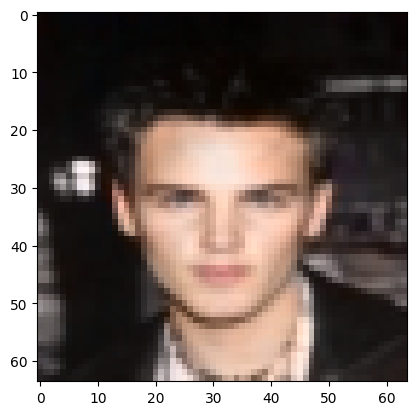

In [7]:
import matplotlib.pyplot as plt

test_dl = model.test_dataloader()
test_batch = next(iter(test_dl))
x_in, x = test_batch
x_in = x_in[:25]

# plt.imshow(lab2rgb(torch.concat((x_in[0], x[0])).permute(1,2,0)))

with torch.no_grad():
    x_tilde = model(x_in)

    plt.imshow(lab2rgb(torch.concat((x_in[0], x_tilde[0])).permute(1,2,0)))

[[0.05074646 0.02695042 0.02364734]
 [0.04267096 0.01900246 0.01608692]
 [0.03023419 0.02182364 0.02500027]
 [0.03180592 0.02663609 0.02860233]
 [0.02700912 0.02759725 0.03321315]
 [0.02410902 0.02796022 0.0381624 ]
 [0.03100657 0.02638281 0.03346778]
 [0.0310809  0.02637467 0.03332935]
 [0.03303396 0.02594186 0.03186296]
 [0.02733877 0.02181231 0.0336449 ]
 [0.02833011 0.02171696 0.03166845]
 [0.02300072 0.02273915 0.03298059]
 [0.03077474 0.02109646 0.02634994]
 [0.02848167 0.02126354 0.03145166]
 [0.02095195 0.01341553 0.02233859]
 [0.02992827 0.01576365 0.02695666]
 [0.04266248 0.01783943 0.02337488]
 [0.03317429 0.01900532 0.02696075]
 [0.0268353  0.02163289 0.03356532]
 [0.02117895 0.0234235  0.03248967]
 [0.02811255 0.02198659 0.02629648]
 [0.02815597 0.02184797 0.02754216]
 [0.02938797 0.0215814  0.02655329]
 [0.02615837 0.02250896 0.02687876]
 [0.02744635 0.01723476 0.01850313]
 [0.01989091 0.01250761 0.01508707]
 [0.02522052 0.01775241 0.01993264]
 [0.02792333 0.0221705  0.02

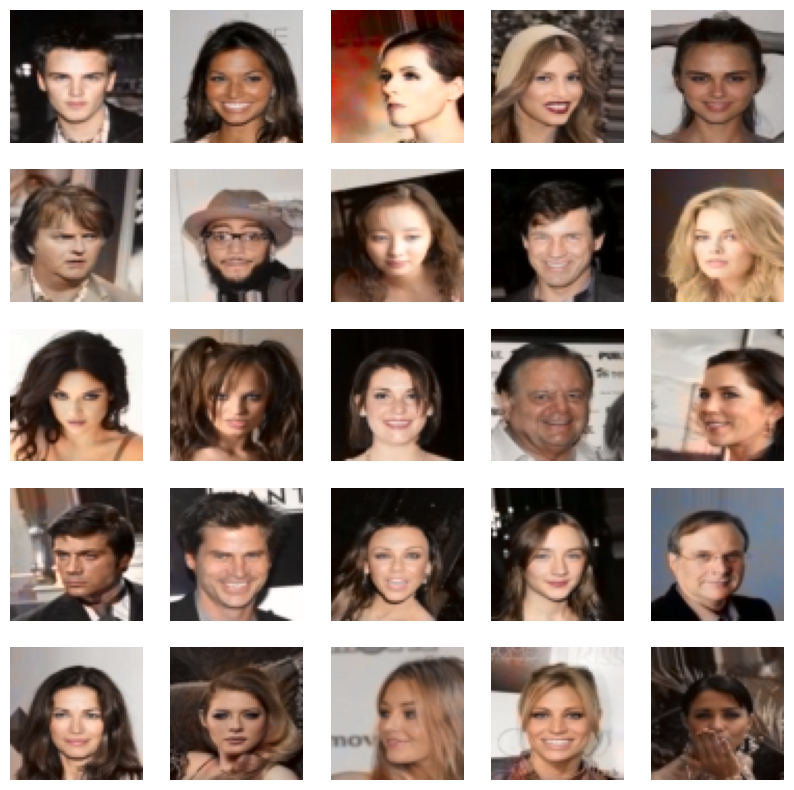

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        idx = i*5 + j
        x_tilde_idx = (x_tilde[idx] - x_tilde[idx].mean()) * 128

        lab = lab2rgb(torch.cat((x_in[idx], x_tilde[idx])).permute(1,2,0))
        # plt.imshow(lab2rgb(torch.concat((x_in[0], x[0]))))

        print(lab[0])

        axs[i, j].imshow(lab)
        axs[i, j].axis('off')
plt.show()